In [149]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import folium
import pandas as pd
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings("ignore")

# Settings
import matplotlib


,id,id_sofer,data_pornire,data_sosire,nr_pasageri,longitudine_pornire,latitudine_pornire,longitudine_sosire,latitudine_sosire,cursa_marcata,durata_cursa
0,id2875421,2,14-03-16 17:24,14-03-16 17:32,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,12-06-16 00:43,12-06-16 00:54,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,19-01-16 11:35,19-01-16 12:10,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,06-04-16 19:32,06-04-16 19:39,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,26-03-16 13:30,26-03-16 13:38,1,-73.973,40.793,-73.973,40.783,N,435


In [ ]:
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8.5, 5)
plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.mpl.rc("figure", figsize=(8.5,5))

# Read data
train_data = pd.read_csv('./input/train.csv')

# View data
train_data.head()

In [144]:
print('Data Shape',train_data.shape)
train_data.info()

Data Shape (1048575, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
id                     1048575 non-null object
id_sofer               1048575 non-null int64
data_pornire           1048575 non-null object
data_sosire            1048575 non-null object
nr_pasageri            1048575 non-null int64
longitudine_pornire    1048575 non-null float64
latitudine_pornire     1048575 non-null float64
longitudine_sosire     1048575 non-null float64
latitudine_sosire      1048575 non-null float64
cursa_marcata          1048575 non-null object
durata_cursa           1048575 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 88.0+ MB


In [145]:
# Statistical summary
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_sofer,1048575.000,1.535,0.499,1.000,1.000,2.000,2.000,2.000
nr_pasageri,1048575.000,1.664,1.314,0.000,1.000,1.000,2.000,9.000
longitudine_pornire,1048575.000,-73.973,0.043,-78.547,-73.992,-73.982,-73.967,-61.336
latitudine_pornire,1048575.000,40.751,0.034,34.360,40.737,40.754,40.768,51.881
longitudine_sosire,1048575.000,-73.973,0.043,-79.818,-73.991,-73.980,-73.963,-61.336
latitudine_sosire,1048575.000,40.752,0.036,32.181,40.736,40.755,40.770,43.912
durata_cursa,1048575.000,962.145,5853.002,1.000,397.000,662.000,1075.000,3526282.000


In [152]:
#detecting the pickups latitude and longitudes which are outside NYC.
outside_NYC = train_data[((train_data.latitudine_pornire <= 40.5774) | (train_data.longitudine_pornire <= -74.15) | (train_data.latitudine_pornire >= 40.9176) | (train_data.longitudine_pornire >= -73.7004))]
#latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
#is negative and becomes -90 at south pole.
#Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
#and is negative.

m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_pickups = outside_NYC.head(25000)

for i,j in outside_pickups.iterrows():
    if j["latitudine_pornire"] != 0:
        folium.Marker([j["latitudine_pornire"], j["longitudine_pornire"]]).add_to(m)
m

In [154]:
# Remove passenger_count outliers
train_data = train_data[train_data['nr_pasageri']>0]
train_data = train_data[train_data['nr_pasageri']<9]

# train_data = train_data[train_data['pickup_longitude'] <= -73.968285]
# train_data = train_data[train_data['pickup_longitude'] >= -74.0059]
# train_data = train_data[train_data['pickup_latitude'] <= 40.748817]
# train_data = train_data[train_data['pickup_latitude'] >= 40.7128]
# train_data = train_data[train_data['dropoff_longitude'] <= -73.968285]
# train_data = train_data[train_data['dropoff_longitude'] >= -74.0059]
# train_data = train_data[train_data['dropoff_latitude'] <= 40.748817]
# train_data = train_data[train_data['dropoff_latitude'] >= 40.7128]

# Remove coordinate outliers
train_data = train_data[train_data['longitudine_pornire'] <= -73.75]
train_data = train_data[train_data['longitudine_pornire'] >= -74.03]
train_data = train_data[train_data['latitudine_pornire'] <= 40.85]
train_data = train_data[train_data['latitudine_pornire'] >= 40.63]
train_data = train_data[train_data['longitudine_sosire'] <= -73.75]
train_data = train_data[train_data['longitudine_sosire'] >= -74.03]
train_data = train_data[train_data['latitudine_sosire'] <= 40.85]
train_data = train_data[train_data['latitudine_sosire'] >= 40.63]

# Remove trip_duration outliers
trip_duration_mean = np.mean(train_data['durata_cursa'])
trip_duration_std = np.std(train_data['durata_cursa'])
train_data = train_data[train_data['durata_cursa']<=trip_duration_mean + 2*trip_duration_std]
train_data = train_data[train_data['durata_cursa']>= trip_duration_mean - 2*trip_duration_std]

# Confirm removal
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_sofer,1033016.000,1.534,0.499,1.000,1.000,2.000,2.000,2.000
nr_pasageri,1033016.000,1.664,1.314,1.000,1.000,1.000,2.000,6.000
longitudine_pornire,1033016.000,-73.974,0.037,-74.030,-73.992,-73.982,-73.967,-73.751
latitudine_pornire,1033016.000,40.751,0.027,40.630,40.737,40.754,40.768,40.850
longitudine_sosire,1033016.000,-73.974,0.033,-74.030,-73.991,-73.980,-73.963,-73.750
latitudine_sosire,1033016.000,40.752,0.030,40.630,40.736,40.755,40.770,40.850
durata_cursa,1033016.000,824.305,645.637,1.000,394.000,655.000,1056.000,12527.000


In [155]:
#detecting the pickups latitude and longitudes which are outside NYC.
outside_NYC = train_data[((train_data.latitudine_pornire <= 40.5774) | (train_data.longitudine_pornire <= -74.15) | (train_data.latitudine_pornire >= 40.9176) | (train_data.longitudine_pornire >= -73.7004))]
#latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
#is negative and becomes -90 at south pole.
#Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
#and is negative.

m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_pickups = outside_NYC.head(25000)

for i,j in outside_pickups.iterrows():
    if j["latitudine_pornire"] != 0:
        folium.Marker([j["latitudine_pornire"], j["longitudine_pornire"]]).add_to(m)
m

In [156]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033016 entries, 0 to 1048574
Data columns (total 11 columns):
id                     1033016 non-null object
id_sofer               1033016 non-null int64
data_pornire           1033016 non-null object
data_sosire            1033016 non-null object
nr_pasageri            1033016 non-null int64
longitudine_pornire    1033016 non-null float64
latitudine_pornire     1033016 non-null float64
longitudine_sosire     1033016 non-null float64
latitudine_sosire      1033016 non-null float64
cursa_marcata          1033016 non-null object
durata_cursa           1033016 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 94.6+ MB


In [174]:
train_data['data_timp_pornire'] = pd.to_datetime(train_data.data_pornire) # Pickups
train_data['data_timp_sosire'] = pd.to_datetime(train_data.data_pornire) # Drop-offs

# Confirm changes
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033016 entries, 0 to 1048574
Data columns (total 15 columns):
id                     1033016 non-null object
id_sofer               1033016 non-null int64
data_pornire           1033016 non-null object
data_sosire            1033016 non-null datetime64[ns]
nr_pasageri            1033016 non-null int64
longitudine_pornire    1033016 non-null float64
latitudine_pornire     1033016 non-null float64
longitudine_sosire     1033016 non-null float64
latitudine_sosire      1033016 non-null float64
cursa_marcata          1033016 non-null object
durata_cursa           1033016 non-null int64
pickup_datetime        1033016 non-null datetime64[ns]
dropoff_datetime       1033016 non-null datetime64[ns]
data_timp_pornire      1033016 non-null datetime64[ns]
data_timp_sosire       1033016 non-null datetime64[ns]
dtypes: datetime64[ns](5), float64(4), int64(3), object(3)
memory usage: 126.1+ MB


In [175]:
print(train_data['data_timp_pornire'].dt.date)

0          2016-03-14
1          2016-12-06
2          2016-01-19
3          2016-06-04
4          2016-03-26
5          2016-01-30
6          2016-06-17
7          2016-05-21
8          2016-05-27
9          2016-10-03
10         2016-10-05
11         2016-05-15
12         2016-02-19
13         2016-01-06
14         2016-05-27
15         2016-05-16
16         2016-11-04
17         2016-04-14
18         2016-06-27
19         2016-05-06
20         2016-02-28
21         2016-01-04
22         2016-09-04
23         2016-06-25
24         2016-03-06
25         2016-02-14
26         2016-02-27
27         2016-06-20
28         2016-06-13
29         2016-03-23
              ...    
1048545    2016-01-14
1048546    2016-03-16
1048547    2016-05-15
1048548    2016-09-04
1048549    2016-05-17
1048550    2016-07-05
1048551    2016-07-01
1048552    2016-05-25
1048553    2016-12-06
1048554    2016-04-02
1048555    2016-02-24
1048556    2016-09-05
1048557    2016-03-05
1048558    2016-04-23
1048559   

In [176]:
# Delimit pickup_datetime variable 

train_data['data_pornire'] = train_data['data_timp_pornire'].dt.date # Extract date
train_data['timp_pornire'] = train_data['data_timp_pornire'].dt.time # Extract time

# Delimit dropoff_datetime variables
train_data['data_sosire'] = train_data['data_timp_sosire'].dt.date # Extract date
train_data['timp_sosire'] = train_data['data_timp_sosire'].dt.time # Extract time

# Additional pickup features
train_data['luna_pornire'] = train_data['data_timp_pornire'].dt.month # Extract month
# train_data['pickup_month'] = train_data.pickup_datetime.dt.to_period('M') # Extract yearmonth
#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
train_data['ora_pornire'] = train_data['data_timp_pornire'].dt.hour # Extract hour
train_data['ziua_pornire'] = train_data['data_timp_pornire'].dt.dayofweek # Extract day of week

# Drop concatentated timestamp columns
train_data.drop(['data_pornire'], axis = 1, inplace = True)
train_data.drop(['data_sosire'], axis = 1, inplace = True)

# Confirm changes
train_data.columns

Index(['id', 'id_sofer', 'nr_pasageri', 'longitudine_pornire',
       'latitudine_pornire', 'longitudine_sosire', 'latitudine_sosire',
       'cursa_marcata', 'durata_cursa', 'pickup_datetime', 'dropoff_datetime',
       'data_timp_pornire', 'data_timp_sosire', 'timp_pornire', 'timp_sosire',
       'luna_pornire', 'ora_pornire', 'ziua_pornire'],
      dtype='object')

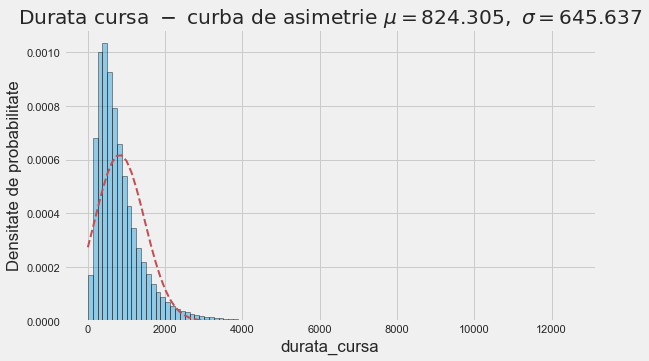

,count,mean,std,min,25%,50%,75%,max
durata_cursa,1033016.000,824.305,645.637,1.000,394.000,655.000,1056.000,12527.000


In [179]:
# Mean distribution
mu = train_data['durata_cursa'].mean()

# Std distribution
sigma = train_data['durata_cursa'].std()
num_bins = 100

# Histogram 
fig = plt.figure(figsize=(8.5, 5))
n, bins, patches = plt.hist(train_data['durata_cursa'], num_bins, normed=1,
                           edgecolor = 'black', lw = 1, alpha = .40)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('durata_cursa')
plt.ylabel('Densitate de probabilitate')

# Adding a title
plt.title(r'$\mathrm{Durata\ cursa\ -\ curba\ de\ asimetrie}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)
#fig.tight_layout()
plt.show()

# Statistical summary
train_data.describe()[['durata_cursa']].transpose()

In [18]:
train_data.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday'],
      dtype='object')

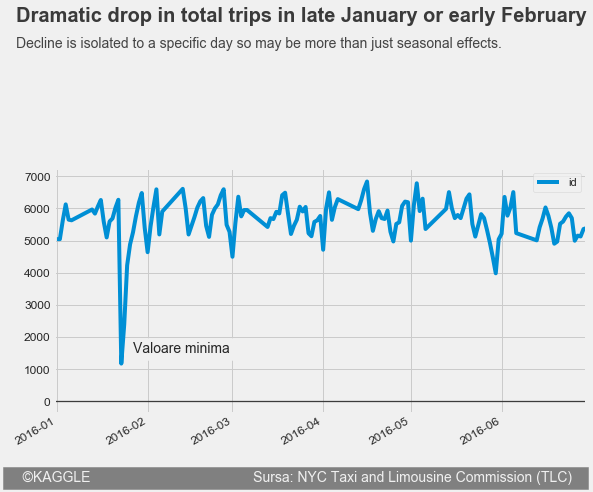

In [181]:
# Summarize total trips by day
pickups_by_day = train_data.groupby('data_timp_pornire').count()['id']

# Create graph
pickups_graph = pickups_by_day.plot(x = 'data_timp_pornire', y = 'id', figsize = (8.5,5),legend = True)

# Customize tick size
pickups_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Bold horizontal line at y = 0
pickups_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

# Customize tick labels of the y-axis
#pickups_graph.set_yticklabels(labels = [-10, '2000   ', '4000   ', '6000   ', '8000   ', '10000   '])

# Add an extra vertical line by tweaking the range of the x-axis
pickups_graph.set_xlim(left = '2015-12-31', right = '2016-06-30')

# Remove the label of the x-axis
pickups_graph.xaxis.label.set_visible(False)

# Add signature bar
pickups_graph.text(x = '2015-12-15', # Adjusts left side of signature bar,has to be in same coordiantes as x-axis
               y = -2500, 
               s = '    ©KAGGLE                                          Sursa: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey')

# Adding a title and a subtitle
pickups_graph.text(x = '2015-12-18', y = 11800,
                   s = "Dramatic drop in total trips in late January or early February",
                   fontsize = 20, weight = 'bold', alpha = .90)

pickups_graph.text(x = '2015-12-18', y = 11000, 
                   s = 'Decline is isolated to a specific day so may be more than just seasonal effects.',
                   fontsize = 14, alpha = .85)
pickups_graph.text(x = '2016-01-27', y = 1500, s = 'Valoare minima',weight = 0, rotation = 0, backgroundcolor = '#f0f0f0', size = 14)
plt.show()

In [183]:
train_data.groupby('data_timp_pornire').count()['id'].sort_values(ascending = True)[[0]]


data_timp_pornire
2016-01-23    1176
Name: id, dtype: int64

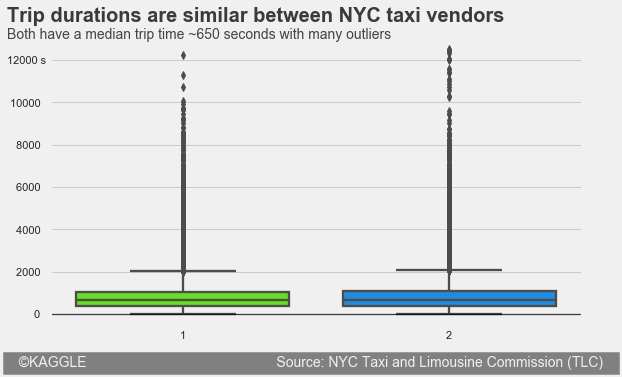

,count,mean,std,min,25%,50%,75%,max
id_sofer,,,,,,,,
1,481547.000,818.493,637.824,1.000,392.000,652.000,1052.000,12218.000
2,551469.000,829.380,652.342,1.000,395.000,657.000,1060.000,12527.000


In [185]:
# Create boxplot
plt.figure(figsize=(8.5,5))
vendor_graph = sns.boxplot(x = 'id_sofer', y = 'durata_cursa', data = train_data, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick labels of the y-axis
vendor_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
vendor_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
vendor_graph.xaxis.label.set_visible(False)
vendor_graph.yaxis.label.set_visible(False)

# Add signature bar
vendor_graph.text(x = -.66, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# # Adding a title and a subtitle
vendor_graph.text(x =-.66, y = 13800, s = "Trip durations are similar between NYC taxi vendors",
               fontsize =20 , weight = 'bold', alpha = .90)
vendor_graph.text(x = -.66, y = 13000.3, 
               s = 'Both have a median trip time ~650 seconds with many outliers',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('id_sofer')['durata_cursa'].describe()

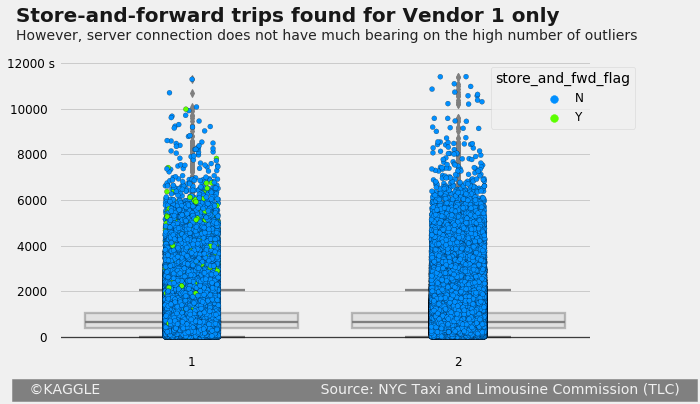

store_and_fwd_flag,N,Y
vendor_id,,
1,661384.000,7877.000
2,767815.000,0.000


In [22]:
# Create boxplot
plt.figure(figsize=(8.5,5))
vendor_graph = sns.boxplot(x = 'vendor_id', y = 'trip_duration', data = train_data, 
                          orient = 'v',color = 'lightgrey', linewidth = 2.3)
plt.setp(vendor_graph.artists, alpha = 0.5)

# Create strip plot
sns.stripplot(data = train_data, x = 'vendor_id', y = 'trip_duration', jitter = 1, size = 5,
             edgecolor = 'black', linewidth = .2,palette = 'gist_rainbow_r',hue = 'store_and_fwd_flag')

# Customize tick size
vendor_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
vendor_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
vendor_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
vendor_graph.xaxis.label.set_visible(False)
vendor_graph.yaxis.label.set_visible(False)

# Add signature bar
vendor_graph.text(x = -.66, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Adding a title and a subtitle
vendor_graph.text(x =-.66, y = 13800, s = 'Store-and-forward trips found for Vendor 1 only',
               fontsize =20 , weight = 'bold', alpha = .90)
vendor_graph.text(x = -.66, y = 13000.3, 
               s = 'However, server connection does not have much bearing on the high number of outliers',
              fontsize = 14, alpha = .85)
# Format legend
vendor_graph.legend(title = 'store_and_fwd_flag', bbox_to_anchor = (.80,1),loc = 2, fontsize=12)
plt.show()

# Statistical summary
train_data.groupby(['vendor_id','store_and_fwd_flag'])['store_and_fwd_flag'].count().unstack().fillna(0)

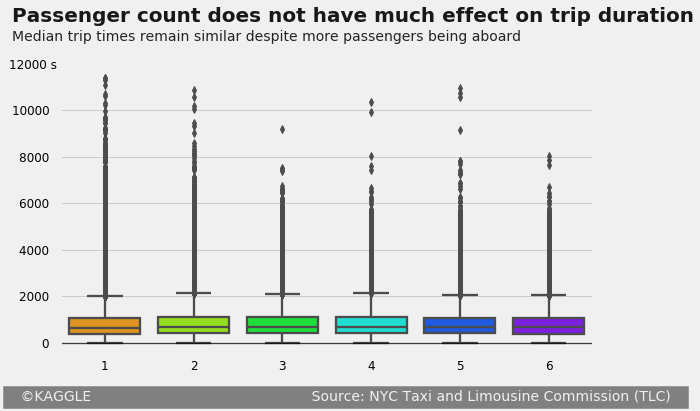

passenger_count,1,2,3,4,5,6
count,1018715.000,206864.000,58989.000,27957.000,76912.000,47639.000
mean,812.699,863.615,854.394,874.580,832.906,825.457
std,634.096,682.049,657.985,689.186,647.936,643.767
min,1.000,1.000,2.000,2.000,2.000,2.000
25%,388.000,412.000,415.000,419.000,397.000,395.000
50%,647.000,681.000,679.000,690.000,661.000,655.000
75%,1043.000,1099.000,1091.000,1115.000,1067.000,1058.000
max,11411.000,10864.000,9197.000,10380.000,10981.000,8041.000


In [23]:
# Settings
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
passenger_graph = sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = train_data, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
passenger_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
passenger_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
passenger_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add an extra vertical line by tweaking the range of the x-axis
#month_graph.set_xlim(left = -1, right = 6)

# Remove the label of the x-axis
passenger_graph.xaxis.label.set_visible(False)
passenger_graph.yaxis.label.set_visible(False)

# Add signature bar
passenger_graph.text(x = -1.1, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Alternative signature bar
# fte_graph.text(x = 1967.1, y = -6.5,
#               s = '________________________________________________________________________________________________________________',
#               color = 'grey', alpha = .70)
# fte_graph.text(x = 1966.1, y = -9,
#               s ='   ©DATAQUEST                                                                               Source: National Center for Education Statistics   ', # copyright symbol ALT + 0169
#               fontsize = 14, color = 'grey', alpha = .7)

# # Adding a title and a subtitle
passenger_graph.text(x =-1.05, y = 13800, s = "Passenger count does not have much effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
passenger_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times remain similar despite more passengers being aboard',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('passenger_count')['trip_duration'].describe().transpose()

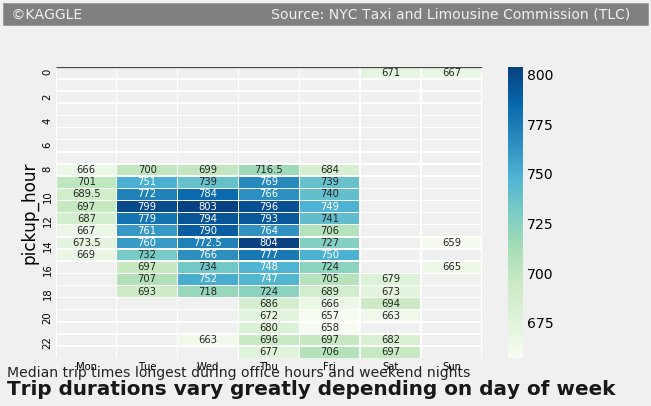

In [24]:
# Trips by Hour and Day of Week
trip_duration_median = train_data['trip_duration'].median()
plt.figure(figsize=(8.5,5))
pickup_hourday = train_data.groupby(['pickup_hour','pickup_weekday'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
hourday_graph.text(x = -.8,  y = -4,
                   s = ' ©KAGGLE                                          Source: NYC Taxi and Limousine Commission (TLC)   ',
fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# # Adding a title and a subtitle
hourday_graph.text(x =-.8, y = 27, s = "Trip durations vary greatly depending on day of week",
               fontsize =20 , weight = 'bold', alpha = .90)
hourday_graph.text(x =-.8, y = 25.5, 
               s = 'Median trip times longest during office hours and weekend nights',
              fontsize = 14, alpha = .85)

# plt.ylabel('pickup_hour (military time)')
# plt.xlabel('pickup_weekday (Mon - Sun)')
# plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

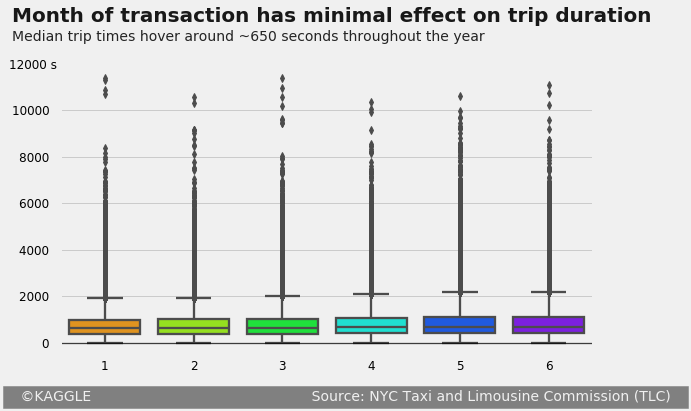

pickup_month,1,2,3,4,5,6
count,226431.000,235043.000,252434.000,247849.000,244581.000,230738.000
mean,779.180,778.272,805.638,834.930,869.895,877.056
std,599.652,582.846,617.997,642.635,702.520,703.833
min,1.000,1.000,1.000,1.000,1.000,1.000
25%,381.000,381.000,390.000,400.000,405.000,411.000
50%,623.000,629.000,646.000,667.000,681.000,687.000
75%,996.000,1005.000,1035.000,1076.000,1112.000,1120.000
max,11411.000,10574.000,11406.000,10380.000,10632.000,11099.000


In [25]:
# Box plot of pickups by month
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
month_graph = sns.boxplot(x = 'pickup_month', y = 'trip_duration', data = train_data, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
month_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
month_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
month_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)


# Add an extra vertical line by tweaking the range of the x-axis
#month_graph.set_xlim(left = -1, right = 6)

# Remove the label of the x-axis
month_graph.xaxis.label.set_visible(False)
month_graph.yaxis.label.set_visible(False)

# Add signature bar
month_graph.text(x = -1.1, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Alternative signature bar
# fte_graph.text(x = 1967.1, y = -6.5,
#               s = '________________________________________________________________________________________________________________',
#               color = 'grey', alpha = .70)
# fte_graph.text(x = 1966.1, y = -9,
#               s ='   ©DATAQUEST                                                                               Source: National Center for Education Statistics   ', # copyright symbol ALT + 0169
#               fontsize = 14, color = 'grey', alpha = .7)

# # Adding a title and a subtitle
month_graph.text(x =-1.05, y = 13800, s = "Month of transaction has minimal effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
month_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times hover around ~650 seconds throughout the year',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('pickup_month')['trip_duration'].describe().transpose()

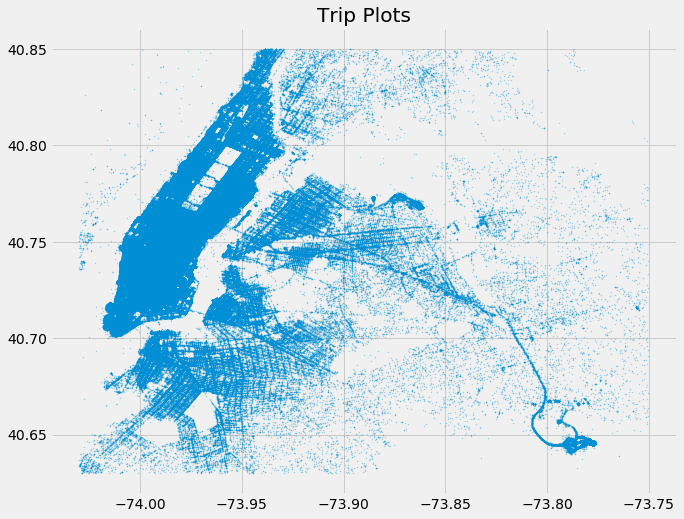

In [26]:
longitude = list(train_data.pickup_longitude) + list(train_data.dropoff_longitude)
latitude = list(train_data.pickup_latitude) + list(train_data.dropoff_latitude)
plt.figure(figsize = (10,8))
plt.plot(longitude,latitude,'.',alpha = .40, markersize = .8)
plt.title('Trip Plots')
plt.show()

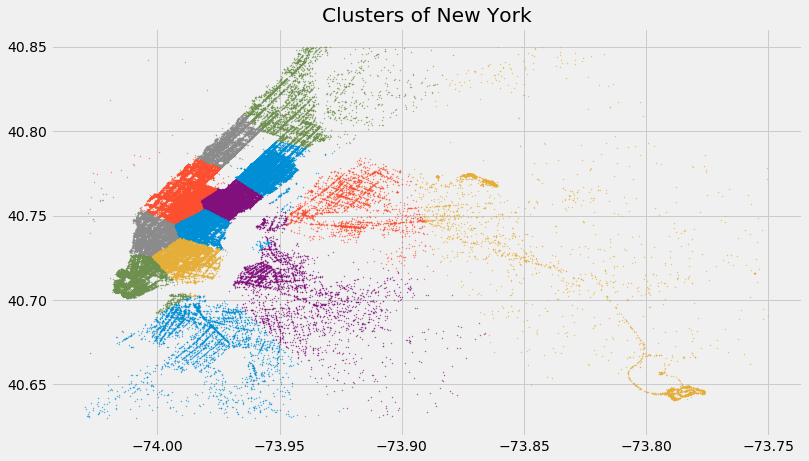

In [27]:
# Create data frame of coordinates
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

# Clusters of New York
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
loc_df = loc_df.sample(200000)
plt.figure(figsize = (12,7))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.8, markersize = 0.8)
plt.title('Clusters of New York')
plt.show()

List the numerical features in decending order by their correlation with trip_duration:

pickup_longitude: 0.3632691702226197
dropoff_longitude: 0.25548835909396256
pickup_latitude: -0.23548982525753842
dropoff_latitude: -0.19720945010930235
pickup_month: 0.059455091448905886
pickup_weekday: -0.03544469782338135
pickup_hour: 0.03025386122067256
passenger_count: 0.015344197884831583


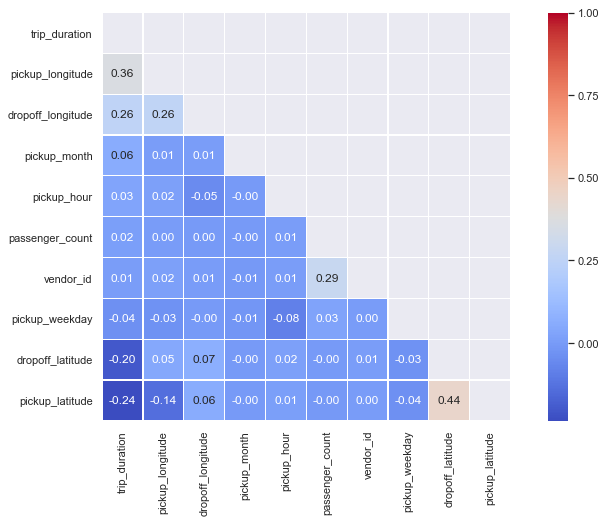

In [29]:
# Correlations to trip_duration
corr = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict = corr['trip_duration'].to_dict()
del cor_dict['trip_duration']
print("List the numerical features in decending order by their correlation with trip_duration:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))
    
# Correlation matrix heatmap
corrmat = train_data.corr()
plt.figure(figsize=(12, 7))

# Number of variables for heatmap
k = 76
cols = corrmat.nlargest(k, 'trip_duration')['trip_duration'].index
cm = np.corrcoef(train_data[cols].values.T)

# Generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values,\
                 xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
plt.show() 

In [30]:
train_data.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_time,dropoff_date,dropoff_time,pickup_month,pickup_hour,pickup_weekday
0,id2875421,2,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,17:24:55,2016-03-14,17:32:30,3,17,0
1,id2377394,1,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12,00:43:35,2016-06-12,00:54:38,6,0,6
2,id3858529,2,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19,11:35:24,2016-01-19,12:10:48,1,11,1
3,id3504673,2,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06,19:32:31,2016-04-06,19:39:40,4,19,2
4,id2181028,2,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26,13:30:55,2016-03-26,13:38:10,3,13,5


In [31]:
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map({'N':0,'Y':1})


In [32]:
train_data.drop(['pickup_date','pickup_time','dropoff_date', 'dropoff_time','id'], 
                axis = 1, inplace = True)

In [33]:
train_data.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_month', 'pickup_hour', 'pickup_weekday'],
      dtype='object')

In [125]:
# Split
# Create matrix of features
X = train_data[['passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday']] # double brackets!

# Create array of target variable 
y = train_data['trip_duration']

# Create train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [126]:
# Fit
# Import model
from sklearn.tree import DecisionTreeRegressor

# Instantiate model object
dtree = DecisionTreeRegressor()

# Fit to training data
dtree.fit(X_train,y_train)

# Predict
y_pred_dtree = dtree.predict(X_test)

# Score It
from sklearn import metrics
print('\nDecision Tree Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test,y_pred_dtree))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_dtree))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_dtree))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_dtree)))


Decision Tree Regression Performance Metrics
R^2= 0.5781324675878932
MAE: 257.90965012386226
MSE: 176199.62436677152
RMSE: 419.7613897999333


In [ ]:
# import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

def data_to_plotly(x):
    k = []
    
    for i in range(0, len(x)):
        k.append(x[i][0])
        
    return k

In [134]:
p1 = go.Scatter(x=data_to_plotly(X), y=y, 
                mode='markers',
                marker=dict(color="darkorange"),
                name="data")

p2 = go.Scatter(x=data_to_plotly(X_test), y=y_1, 
                mode='lines',
                line=dict(color="cornflowerblue"),
                name="max_depth=2")

p3 = go.Scatter(x=data_to_plotly(X_test), y=y_2, 
                mode='lines',
                line=dict(color="yellowgreen"),
                name="max_depth=5")

layout = go.Layout(xaxis=dict(title="data"),
                   yaxis=dict(title="target"),
                   title="Decision Tree Regression"
                  )
fig = go.Figure(data=[p1, p2, p3], layout=layout)

NameError: name 'go' is not defined

In [118]:
# Predict
x_test_cornel = X_test.iloc[0]
print(x_test_cornel)
y_pred_dtree = dtree.predict(X_test)
print(y_pred_dtree[0])

passenger_count        1.000
pickup_longitude     -73.985
pickup_latitude       40.724
dropoff_longitude    -73.982
dropoff_latitude      40.728
store_and_fwd_flag     0.000
pickup_month           1.000
pickup_hour            3.000
pickup_weekday         5.000
Name: 963865, dtype: float64
148.0


In [119]:
# Load test data
test_data = pd.read_csv('./input/test_c.csv')

# Test data info
test_data.info()

# Test data shape
print('shape',test_data.shape)
print(test_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 9 columns):
id                    1 non-null object
vendor_id             1 non-null int64
pickup_datetime       1 non-null object
passenger_count       1 non-null int64
pickup_longitude      1 non-null float64
pickup_latitude       1 non-null float64
dropoff_longitude     1 non-null float64
dropoff_latitude      1 non-null float64
store_and_fwd_flag    1 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 152.0+ bytes
shape (1, 9)
          id  vendor_id pickup_datetime  passenger_count  pickup_longitude  \
0  id3004672          1  30-06-16 23:59                1           -73.988   

   pickup_latitude  dropoff_longitude  dropoff_latitude store_and_fwd_flag  
0           40.732            -73.990            40.757                  N  


In [120]:
# Convert timestamps to date objects
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime) # Pickups

# Delimit pickup_datetime variable 
test_data['pickup_date'] = test_data['pickup_datetime'].dt.date # Extract date
test_data['pickup_time'] = test_data['pickup_datetime'].dt.time # Extract time

# Additional pickup features
test_data['pickup_month'] = test_data['pickup_datetime'].dt.month # Extract month

#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
test_data['pickup_hour'] = test_data['pickup_datetime'].dt.hour # Extract hour
test_data['pickup_weekday'] = test_data['pickup_datetime'].dt.dayofweek # Extract day of week

# Encode categorical variables
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].map({'N':0,'Y':1})

In [121]:
X_test= test_data[['passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday']]

# Feed features into random forest
y_pred= dtree.predict(X_test)
print(y_pred[0])
submission = pd.DataFrame({
    'trip_duration': y_pred
})

print(submission)

625.0
   trip_duration
0        625.000


In [92]:
# Create contest submission
submission = pd.DataFrame({
    'Id':test_data['id'],
    'trip_duration': y_pred
})
submission.to_csv('mytaxisubmission.csv',index = False)